# Likelihood and Nested Sampling 

Accretion disk model with the addition of the $q$ parameter.

### Import functions and stuff from pydd

In [1]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [2]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul,  
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

## True values for plotting

In [5]:
m1 = 1e5 * MSUN # kg
m2 = 10 * MSUN # kg
r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100
sigma0 = 1.5e10 / Mach**2
alpha = -1/2
chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)
q = m2/m1

In [7]:
# from priors to true vals in translated system

true_value = np.array([chirp_mass, sigma0, alpha, q])

log_sigma0_true= np.log10(true_value[1])
m_true = 0
alpha_true = 0
logq_true = np.log10(true_value[3])

## Nested Sampling results (noiseless)

In [15]:
with open('sampling-results/sampling_results_accwithq.pkl', 'rb') as f:
    data_out = pickle.load(f)

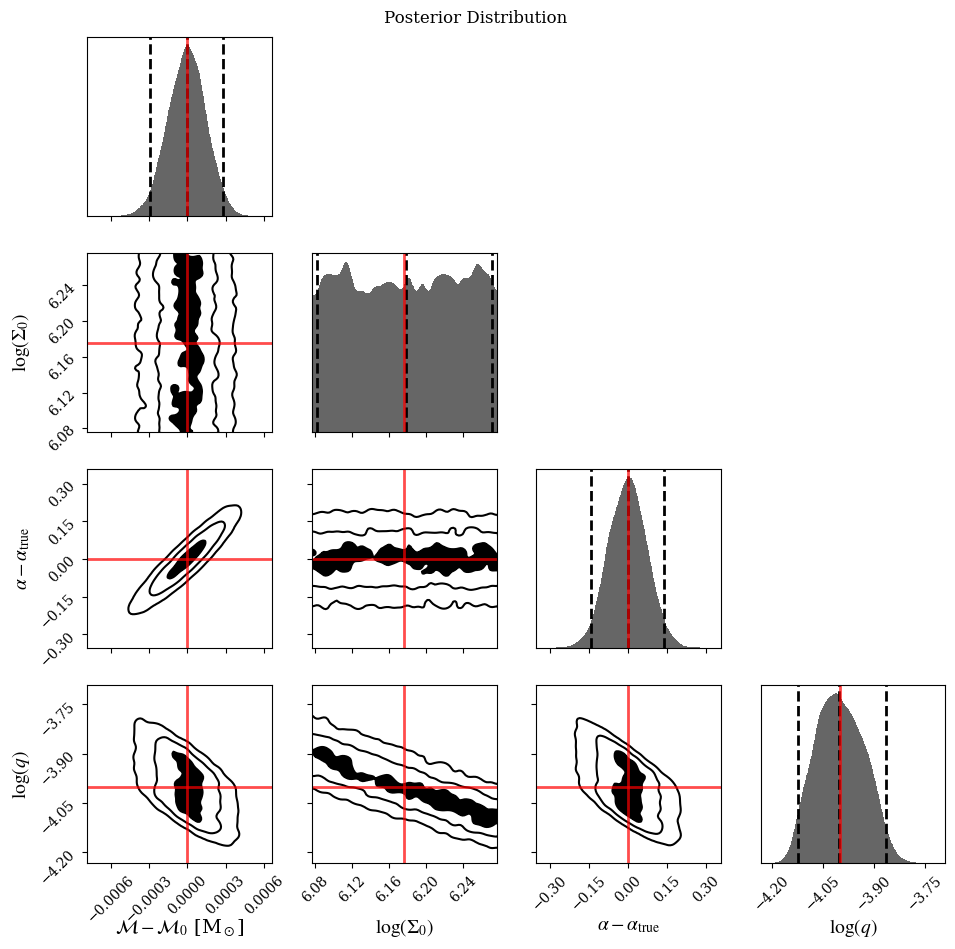

In [16]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\Sigma_0)$", r'$\alpha - \alpha_{\mathrm{true}}$', r"$\log(q)$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    data_out, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[m_true, log_sigma0_true, alpha_true, logq_true] 
    #verbose=True
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
plt.show()

In [17]:
class CustomResults:
    def __init__(self, samples, log_weights):
        self.samples = samples
        self.logwt = log_weights

    def __getitem__(self, key):
        if key == 'samples':
            return self.samples
        elif key == 'logwt':
            return self.logwt
        else:
            raise KeyError(f"Invalid key '{key}'")

    def importance_weights(self):
        # Calculate importance weights for each set of samples based on log weights
        return np.exp(self.logwt - np.max(self.logwt))

    def __len__(self):
        # Return the number of sets of samples (number of rows)
        return self.samples.shape[0]

In [21]:
chirp_mass_posterior = data_out.samples[:, 0]
log_sigma0_posterior = data_out.samples[:, 1]
alpha_posterior = data_out.samples[:, 2]
log_q_posterior = data_out.samples[:, 3]

chirp_mass_posterior_transformed = (chirp_mass_posterior * MSUN + true_value[0]) / MSUN # in units of solar masses
sigma0_posterior_transformed = 10**(log_sigma0_posterior)
alpha_posterior_transformed = (alpha_posterior + true_value[2]) 
q_posterior_transformed = 10**(log_q_posterior)

transformed_samples = np.vstack((chirp_mass_posterior_transformed, sigma0_posterior_transformed, alpha_posterior_transformed, q_posterior_transformed)).T

# Calculate log weights from results_1d 
log_weights = data_out.logwt

# Instantiate custom results object
custom_results = CustomResults(transformed_samples, log_weights)

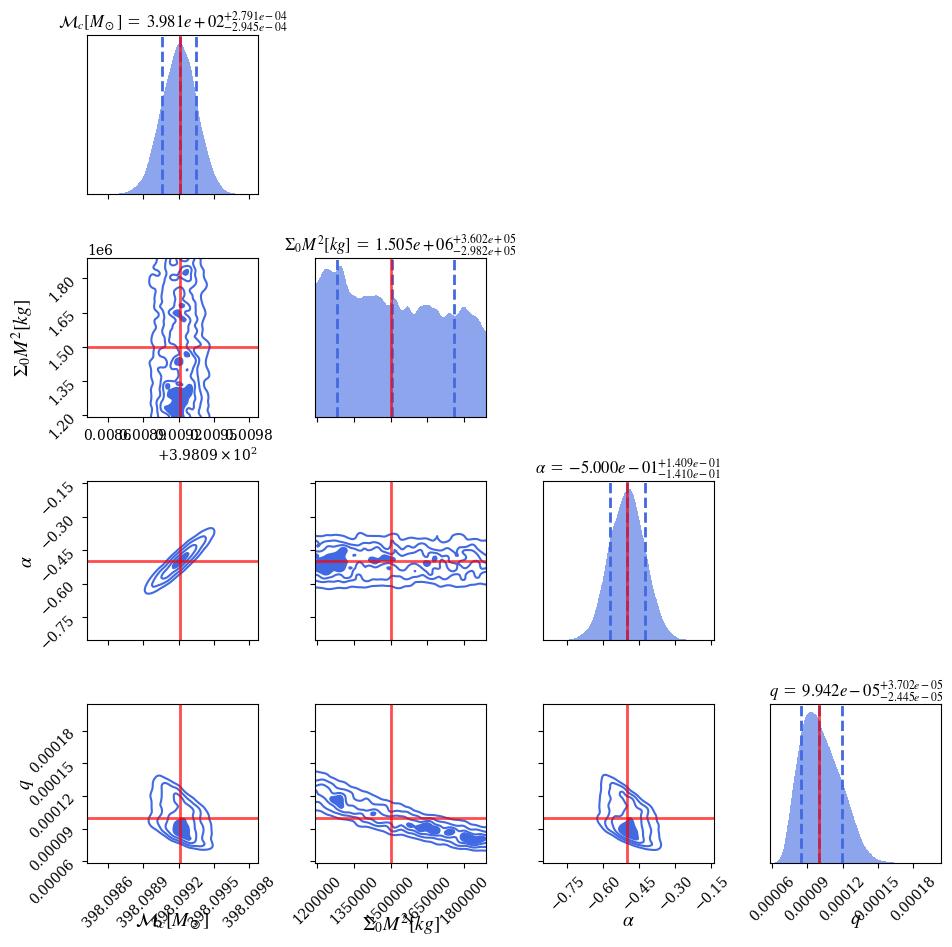

In [22]:
from matplotlib.ticker import ScalarFormatter

labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2 [kg]$", r"$\alpha$", '$q$']

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    custom_results,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1], true_value[2], true_value[3]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

---

# Including the noise ? (TO CHECK)

In [282]:
# Define the signal: 

noisy_signal = waveform(_AD_D, FS, S_n)[2] # 0: noiseless, 1: noise-only, 2: noisy

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


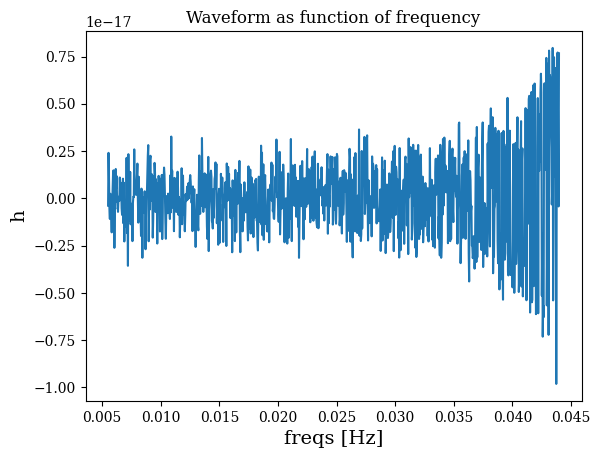

In [283]:
# see the waveform

plt.plot(FS[::-1], noisy_signal)
plt.xlabel('freqs [Hz]')
plt.ylabel('h')
plt.title('Waveform as function of frequency');

Upon redefinition of a few functions we perform the same routine as before.

In [284]:
def noisy_calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) # h is the model/template
    wf_d = noisy_signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def noisy_loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = mycalculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = noisy_calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

In [ ]:
def noisy_ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (4,)
    v_m = np.array([0.7]) # M_sun
    v_t = np.array([0.45]) # M_sun
    v_n = np.array([np.log10((true_value[1] + prior_list[1]) / (true_value[1] - prior_list[1]))])
    v_d = np.array([np.log10((true_value[3] + prior_list[3]) / (true_value[3] - prior_list[3]))])
    return np.array([2 * v_m * (u[0]-0.5), v_n * u[1], 2 * v_t * (u[2]-0.5), v_d * u[3]]).reshape(4, )


def noisy_unpack(x: np.ndarray) -> myAccretionDisk:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    # unpack x extraction
    dMc = x[0]
    dsigma0 = x[1] 
    dalpha = x[2]
    dq = x[3]
    choose_prior = [prior_list[1], prior_list[3]]  # for log-prior
    
    Mc = _AD_D.chirp_mass + dMc * MSUN
    q = (_AD_D.Binary_init.q - choose_prior[1]) * 10**dq
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    sigma0 = (_AD_D.sigma0 - choose_prior[0]) * 10**dsigma0
    alpha = _AD_D.alpha + dalpha
    
    r_s = 2 * G * m_1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100
    DL = _AD_D.Binary_init.dist
    
    return myAccretionDisk(mach=Mach, m1=m_1, m2=m_2, r0=r0, dist=DL, sigma0=sigma0, alpha=alpha, chirp_mass=Mc)

def noisy_get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = noisy_unpack(x)
    return noisy_loglikelihood_fft(ad_h, _AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

## Nested sampling 

In [ ]:
# Initialize the nested sampler
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the high-likelihood region!
noisy_sampler = dynesty.NestedSampler(noisy_get_ll_fft, noisy_ptform, 4, nlive=1000, bound='single')

# Run the nested sampling
noisy_sampler.run_nested(dlogz=1)  # dlogz is the threshold on the change in evidence that stops the run

# Extract the results
noisy_results = noisy_sampler.results

In [ ]:
noisy_chirp_mass_posterior = noisy_results.samples[:, 0]
noisy_sigma0_posterior = noisy_results.samples[:, 1]
noisy_alpha_posterior = noisy_results.samples[:, 2]
noisy_q_posterior = noisy_results.samples[:, 3]
noisy_log_weights = noisy_results.logwt

noisy_chirp_mass_posterior_transformed = (noisy_chirp_mass_posterior * MSUN + true_value[0]) / MSUN # in units of solar masses
noisy_sigma0_posterior_transformed = (true_value[1] * 10**(noisy_sigma0_posterior) - prior_list[1] * 10**(noisy_sigma0_posterior))
noisy_q_posterior_transformed = (true_value[3] * 10**(noisy_q_posterior) - prior_list[3] * 10**(noisy_q_posterior)) 
noisy_alpha_posterior_transformed = (noisy_alpha_posterior + true_value[2]) 

noisy_transformed_samples = np.vstack((noisy_chirp_mass_posterior_transformed, noisy_sigma0_posterior_transformed, noisy_alpha_posterior_transformed, noisy_q_posterior_transformed)).T

# Instantiate custom results object
noisy_custom_results = CustomResults(noisy_transformed_samples, noisy_log_weights)

In [ ]:
labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2 [kg]$", r"$\alpha$", 'q']

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    noisy_custom_results,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1], true_value[2], true_value[3]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

# On the degeneracy of the $q \Sigma_0$ pair

The pair of $q \Sigma_0$ parameters is half degenerate, meaning that they always appear together in the expressions to calculate the waveform which goes into the likelihood function. 

This means that in calculating the posterior we always have thri contribution as a whole, making it difficult to distinguish whether the disk is compatible with larger $q$s and smaller $\Sigma_0$ or vice versa. 

The interested quantities whose I am referring are: 


- Amplitude (in the amplitude function); 
- $\Psi$ functions; 
- $\ddot{\Phi}$, through $\frac{df}{dt}$. 